## Show, Attend and Tell - архитектера  сети для создания подписей к фотографиям
Статья: https://arxiv.org/pdf/1502.03044.pdf | https://www.tensorflow.org/tutorials/text/image_captioning?hl=ru

#### Импорт библиотек

In [1]:
import tensorflow as tf

from keras.layers import Input, Dense, LSTM, GRU, Dropout, Embedding, TextVectorization
from keras.layers import StringLookup, BatchNormalization, Add, Activation, concatenate
from keras.models import Model, load_model
import keras

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import collections
import pickle
import random
import time
import json
import os

### Вспомогательные функции (красивой визуализации)

In [48]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

def progress_bar(n_iter, n_total, prefix='Progress: ', suffix='', length=55, fill='█', lost='-'):
    percent = f"{100 * (n_iter / float(n_total)) :.1f}"
    filled_length = round(length * n_iter // n_total)
    bar = fill * filled_length + lost * (length - filled_length)
    print(f'\r{prefix}[{n_iter}/{n_total}] |{bar}| {percent}% {suffix}', end=' '*40)
    if n_iter == n_total:
        print()

        
def evaluate_one_image(image_tensor, temperature=0.0):
    result, att_maps = [word_to_index('<start>')], [None]
    
    hid_state = tf.zeros([1, units])
    dec_input = tf.expand_dims([word_to_index('<start>')], 1)

    features = encoder(image_tensor, training=False)
    for i in range(1, max_seq_length):
        predictions, hid_state, att_map = decoder([dec_input, hid_state, features], training=False)

        if temperature and False:  # not working
            dec_input = np.argmax(np.random.multinomial(1, predictions / temperature), axis=-1)
            # dec_input = tf.argmax(tf.multinomial(predictions / temperature, num_samples=1), axis=-1)
            # tf.random.categorical(preds / temperature, num_samples=1)
        else:
            dec_input = tf.argmax(predictions, axis=-1)
        
        att_maps.append(att_map.numpy())
        result.append(np.squeeze(dec_input))
        
        if result[-1] == word_to_index('<end>'):
            break
    
    return ' '.join([index_to_word(i).numpy().decode('utf-8') for i in result]), np.array(result), att_maps

def run_and_show_attention(image_path, temperature=0.0):
    img, _ = load_image(image_path)
    img_tensor = image_embedding_model(tf.expand_dims(img, 0))[0]
    img_tensor = tf.reshape(img_tensor, (1, -1, img_tensor.shape[-1]))
    
    result, result_idx, attention_maps = evaluate_one_image(img_tensor, temperature=temperature)
    
    img = Image.open(image_path)
    plot_attention_maps(img, result.split(), attention_maps)
#     t = plt.suptitle(result)
#     t.set_y(1.05)
    plt.suptitle(result).set_y(1.05)
    plt.imshow(img)

def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(1, len_result):
        att_map = attention_map[i].reshape((8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(3, grid_size, i)
        titles.append(ax.set_title(str_tokens[i]))
        img = ax.imshow(image)
        ax.imshow(att_map, cmap='gray', alpha=0.6, extent=img.get_extent(), clim=[0.0, np.max(att_map)])
        plt.axis('off')

    plt.tight_layout()

### Пути до датасета

In [3]:
PATH_DATASET    = "D:\BigDataSets\ImageCaption_MS_COCO"
PATH_IMAGES     = os.path.join(PATH_DATASET, "train2014")
PATH_IMAGES_EMB = os.path.join(PATH_DATASET, "train2014_InceptionEMB")
PATH_CAPTIONS   = os.path.join(PATH_DATASET, "captions\captions_train2014.json")
SIZE_DATASET    = 30_000  # * 5 captions
LOAD_TEXT_VEC   = True

### Загрузка и подготовка датасета MS-COCO (13GB, 82K)

In [4]:
with open(PATH_CAPTIONS, 'r') as f:
    annotations = json.load(f)

image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = os.path.join(PATH_IMAGES, f'COCO_train2014_{str(val["image_id"]).zfill(12)}.jpg')
    image_path_to_caption[image_path].append(caption)

all_image_paths = list(image_path_to_caption.keys())
random.shuffle(all_image_paths)  # shuffle dataset
print("All images:", len(all_image_paths))
# print(*all_image_paths[:10], sep='\n')

# Select the first SIZE_DATASET all_image_paths from the shuffled set.
# Each image id has 5 captions associated with it, so that will lead to SIZE_DATASET*5 examples.
image_paths = all_image_paths[:SIZE_DATASET]
print("Train images:", len(image_paths))

captions = []
image_path_vector = []

for image_path in image_paths:
    caption_list = image_path_to_caption[image_path]
    captions.extend(caption_list)
    image_path_vector.extend([image_path] * len(caption_list))

del all_image_paths, image_path_to_caption

All images: 82783
Train images: 30000


20006 20006
<start> A man about to grind a rail on a skateboard <end>
<start> A living room filled with furniture and a piano. <end>
<start> A very colorful room filled with nice furniture. <end>
<start> A brightly lit living room setting with quaint furniture. <end>
<start> A living room with a couch, a chair and a piano. <end>


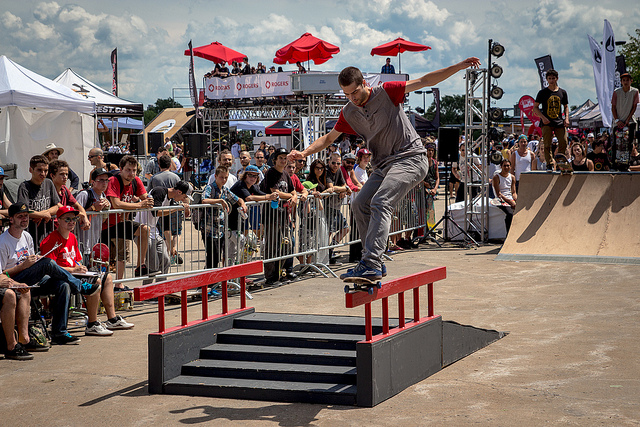

In [5]:
rand_idx = random.randint(0, len(image_paths))

print(len(captions), len(image_path_vector))
print(*captions[rand_idx*5:(rand_idx+1)*5], sep='\n')
Image.open(image_path_vector[rand_idx*5])

# print(*captions[20000:20005], sep='\n')
# Image.open(image_path_vector[20000])

### Image embedding CNN model (InceptionResNetV2)
- продвинутая модель от Google
- заранее обученная модель для классификации (на ImageNet)
- выделяет смысловые части из изображения

In [5]:
image_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet')
# image_model.summary()

new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_embedding_model = tf.keras.Model(new_input, hidden_layer)
print(hidden_layer.shape)


def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

(None, None, None, 1536)


## Кэширование вывода модели в память
Один проход по всем изображениям CNN моделью и сохранение embedding-а в память (.npy) для текущей выбоки тренировочного набора

In [6]:
# DELETE old embeddings
for file in os.listdir(PATH_IMAGES_EMB):
    filepath = os.path.join(PATH_IMAGES_EMB, file)
    os.unlink(filepath)

# IMAGE DATASET
image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64)  # Change batch_size to optimize

for image, path in image_dataset:  # for image, path in tqdm(image_dataset) - для кеширования мало ОЗУ
    batch_embedding = image_embedding_model(image)
    # Shape from (8, 8, 2048) to (64, 2048);;; Iv3 = (8, 8, 2048); IRNv2 = (8, 8, 1536)
    batch_embedding = tf.reshape(batch_embedding, (batch_embedding.shape[0], -1, batch_embedding.shape[-1]))

    for p, b_e in zip(path, batch_embedding):
        p = p.numpy().decode("utf-8")
        p_e = os.path.join(PATH_IMAGES_EMB, p.split('\\')[-1])
        np.save(p_e, b_e.numpy())  # Save the embedding to file (img).npy

### Предварительная обработка и создание токенизатора

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.] [    0     0     0     0     0     0     0     0     1   766 16646 21940
 21351 15284  9872  5717  3214  1873  1089   678   481   311   220   151
   119    77    53    48    32    24    14     5     9     7     8    12
     6     4     2     4     4     3     4     4     0     2     2     2
     1     1]


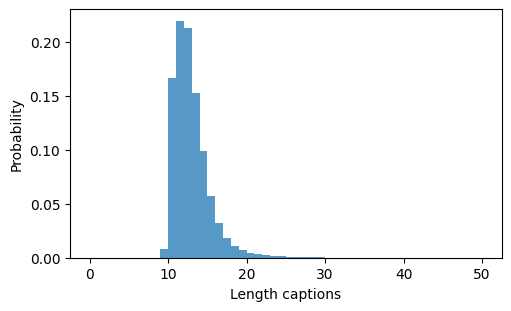

In [8]:
cap_lens = [len(c.split()) for c in captions]
counts, bins = np.histogram(cap_lens, 50, range=(0., 50.))
print(bins, counts)

fig, ax = plt.subplots(figsize=(5,  3), layout='constrained')
plt.hist(bins[:-1], bins, weights=counts, density=True, facecolor='C0', alpha=0.75)
ax.set_xlabel('Length captions')
ax.set_ylabel('Probability')
plt.show()

In [7]:
# We will override the default standardization of TextVectorization to preserve "<>", we preserve for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    inputs = tf.strings.regex_replace(inputs, r"[^\w\s<>]", "")
    return inputs

# Max word count for a caption.
max_seq_length = 24  # len(47, 12.45)
# Use the top 5000 words for a vocabulary.
vocabulary_size = 6_500

# CAPTION DATASET
caption_dataset = tf.data.Dataset.from_tensor_slices(captions)

# TOKENIZER
if not LOAD_TEXT_VEC:
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_seq_length,
    ngrams=None)

tokenizer.adapt(caption_dataset)

### Сохранение или загрузка обученного токенизатора

In [19]:
print("Old:", tokenizer("truck car man pizza cat lion $NoName$"))

# Save tokenizer
if not LOAD_TEXT_VEC:
    # Pickle the config and weights
    with open("models/tokenizer_.pkl", "wb") as file:
        pickle.dump({'config': tokenizer.get_config(),
                     'weights': tokenizer.get_weights()}, file)

# Load tokenizer
if LOAD_TEXT_VEC: 
    with open("models/tokenizer.pkl", "rb") as file:
        from_disk = pickle.load(file)
    tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
    # You have to call `adapt` with some dummy data (BUG in Keras) 
    tokenizer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
    tokenizer.set_weights(from_disk['weights'])

print("New:", tokenizer("truck car man pizza cat lion $NoName$"))

Old: tf.Tensor(
[ 125  136   12   62   49 4589    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(24,), dtype=int64)
New: tf.Tensor(
[ 125  136   12   62   49 4589    1    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(24,), dtype=int64)


### Токенизация подписей (к фотографиям)

In [20]:
caption_token_dataset = caption_dataset.map(tokenizer)

In [ ]:
word_to_index = StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
index_to_word = StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)
print(tokenizer.get_config())
print(*tokenizer.get_weights()[0][:])

### Разделение данных для обучения, валидации и тестирования (70-15-15)

In [21]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_path_vector, caption_token_dataset):
    img_to_cap_vector[img].append(cap)

# Create training, validation and test sets using an 70-15-15 split randomly.
image_keys = list(img_to_cap_vector.keys())
random.shuffle(image_keys)

slice_first = int(len(image_keys) * 0.90)   # 0.7
slice_second = int(len(image_keys) * 0.94)  # 0.85
img_name_train_keys, img_name_val_keys, img_name_test_keys = \
    image_keys[:slice_first], image_keys[slice_first:slice_second], image_keys[slice_second:]

# Train
image_name_train = []
caption_train = []
for img_name in img_name_train_keys:
    capt_len = len(img_to_cap_vector[img_name])
    image_name_train.extend([img_name] * capt_len)
    caption_train.extend(img_to_cap_vector[img_name])

# Validate
image_name_val = []
caption_val = []
for img_name in img_name_val_keys:
    capt_len = len(img_to_cap_vector[img_name])
    image_name_val.extend([img_name] * capt_len)
    caption_val.extend(img_to_cap_vector[img_name])

# Test
image_name_test = []
caption_test = []
for img_name in img_name_test_keys:
    capt_len = len(img_to_cap_vector[img_name])
    image_name_test.extend([img_name] * capt_len)
    caption_test.extend(img_to_cap_vector[img_name])

In [22]:
len(image_name_train), len(caption_train), len(image_name_val), len(caption_val), len(image_name_test), len(caption_test)

(135076, 135076, 6004, 6004, 9004, 9004)

### Переменные (гипер-параметры) обучения

In [23]:
# Feel free to change these parameters according to your system's configuration
EPOCHS = 14
BATCH_SIZE = 64
BUFFER_SIZE = 1000
NUM_STEPS = len(image_name_train) // BATCH_SIZE

RESTORE = False
SAVING = True

embedding_dim = 384
units = 512
# Shape of the vector from InceptionV3 is (64, 2048). Two variables represent that vector shape.
features_shape = 1536  # 2048 or 1536
attention_features_shape = 64

### Создание основного датасета
Оптимизация датасетов _<a href="https://www.tensorflow.org/guide/data_performance?hl=ru#prefetching">документация</a>_

In [24]:
# Load the numpy files
def load_cache_img(img_name, cap):
    img_arr = np.load(os.path.join(PATH_IMAGES_EMB, img_name.decode('utf-8').split('\\')[-1] + '.npy'))
    return img_arr, cap

def load_cache_img_add_path(img_name, cap):
    img_arr = np.load(os.path.join(PATH_IMAGES_EMB, img_name.decode('utf-8').split('\\')[-1] + '.npy'))
    return img_name, img_arr, cap

def make_dataset(image_block, caption_block, bs=BATCH_SIZE, save_path=False, prefetch=True, cache=False):
    ds = tf.data.Dataset.from_tensor_slices((image_block, caption_block))
    
    # Use map to load the numpy files in parallel
    if not save_path:
        ds = ds.map(lambda item1, item2: tf.numpy_function(load_cache_img, [item1, item2], [tf.float32, tf.int64]),
                    num_parallel_calls=tf.data.AUTOTUNE)         # Подгрузка изображений с диска
    else:
        ds = ds.map(lambda item1, item2: tf.numpy_function(load_cache_img_add_path, [item1, item2],
                                                           [tf.string, tf.float32, tf.int64]),
                    num_parallel_calls=tf.data.AUTOTUNE)         # Подгрузка изображений с диска + путь
    
    # Shuffle and batch
    ds = ds.shuffle(BUFFER_SIZE).batch(bs, drop_remainder=True)  # Перемешивать и выделять пакеты
    
    if prefetch:
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)           # Предварительная загрузка данных для скорости
    if cache:
        ds = ds.cache(filename='cache/file')                     # Кеширование для скорости, но ОЗУ жрет и файл нужен
        
    return ds


dataset_train = make_dataset(image_name_train, caption_train, prefetch=True)
dataset_valid = make_dataset(image_name_val, caption_val, bs=BATCH_SIZE*2, prefetch=True)
dataset_test = make_dataset(image_name_test, caption_test, bs=BATCH_SIZE*2, prefetch=True)
dataset_test_path = make_dataset(image_name_test, caption_test, bs=1, save_path=True, prefetch=False)

In [ ]:
# Check dataset correction and shape
for im_name, im_t, cap in dataset_test_path.as_numpy_iterator():
    im = Image.open(im_name[0].decode('utf-8'))
    print(*[index_to_word(w).numpy().decode('utf-8') for w in cap[0]])
    plt.imshow(im)
    print(im_t.shape)
    print(cap.shape)
    print(cap[0])
    break

### Модели (encoder, attention, decoder, model)

In [53]:
# ENCODER
inp = Input(shape=(attention_features_shape, features_shape))
out_features = Dense(embedding_dim, activation='relu')(inp)  # activation='relu'
out_features = Dropout(0.2)(out_features)
encoder = Model(inp, out_features, name='encoder')

In [54]:
# ATTENTION (Bahdanau)
inp_features = Input(shape=(attention_features_shape, embedding_dim))

inp_hidden_state = Input(shape=(units,))
hidden_state_time_axis = tf.expand_dims(inp_hidden_state, axis=1)

features_hidden = Dense(units, activation='relu')(inp_features)                     # activation='relu'
hidden_state_time_axis = Dense(units, activation='relu')(hidden_state_time_axis)    # == +15% to speed loss train
features_hidden = Dropout(0.2)(features_hidden)
hidden_state_time_axis = Dropout(0.2)(hidden_state_time_axis)
attention_hidden_score = Activation('tanh')(features_hidden + hidden_state_time_axis)
attention_weights = tf.nn.softmax(Dense(1)(attention_hidden_score), axis=1)

context_vector = attention_weights * inp_features
context_vector = tf.reduce_sum(context_vector, axis=1)

attention = Model([inp_features, inp_hidden_state], [context_vector, tf.squeeze(attention_weights)], name='attention')

In [55]:
# DECODER
inp_x_word = Input(shape=(1,))
inp_features = Input(shape=(attention_features_shape, embedding_dim))
inp_hidden_state = Input(shape=(units,))

x_word_emb = Embedding(vocabulary_size, embedding_dim)(inp_x_word)
context_vector, _attention_weights = attention([inp_features, inp_hidden_state])

x_concat = Dropout(0.15)(concatenate([tf.expand_dims(context_vector, 1), x_word_emb], axis=-1))
rnn_output, h_state = GRU(units, return_sequences=True, return_state=True, recurrent_initializer="glorot_uniform")(x_concat)

rnn_output = tf.reshape(rnn_output, (-1, rnn_output.shape[-1]))
x = Dropout(0.25)(Dense(units, activation='relu')(rnn_output))  # activation='relu' == +15% to speed loss train
x = Dense(vocabulary_size, activation='softmax')(x)

decoder = Model([inp_x_word, inp_hidden_state, inp_features], [x, h_state, _attention_weights], name='decoder')

In [20]:
encoder.summary()
attention.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 1536)]        0         
                                                                 
 dense (Dense)               (None, 64, 384)           590208    
                                                                 
 dropout (Dropout)           (None, 64, 384)           0         
                                                                 
Total params: 590,208
Trainable params: 590,208
Non-trainable params: 0
_________________________________________________________________
Model: "attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512)]        0           []                               
 

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0006, rho=0.97)
loss_cross = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def loss_masked(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    sub_loss = loss_cross(real, pred)

    mask = tf.cast(mask, dtype=sub_loss.dtype)
    sub_loss *= mask
    return tf.reduce_mean(sub_loss)


### Сохранялки и загрузка от: tensorflow | keras

In [ ]:
# Load save TensorFlow2
if False and RESTORE:
    checkpoint_path = "./models/ckpt"
    ckpt = tf.train.Checkpoint(encoder=encoder,
                               decoder=decoder,
                               optimizer=optimizer)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)
    start_epoch = 0

    if ckpt_manager.latest_checkpoint:
        start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
        ckpt.restore(ckpt_manager.latest_checkpoint)  # restoring the latest checkpoint in checkpoint_path

In [26]:
# Load save Keras
if RESTORE:
    encoder.load_weights("models/enc_w_rp.h5")  # = load_model("models/enc.h5")
    decoder.load_weights("models/dec_w_rp.h5")  # = load_model("models/dec.h5")

### Обучение

In [57]:
@tf.function
def train_step(image_tensor, target_caption):
    loss = 0.

    # initializing the hidden state for each batch because the captions are not related from image to image
    batch_size = target_caption.shape[0]
    hid_state = tf.zeros([batch_size, units])
    dec_input = tf.expand_dims([word_to_index('<start>')] * batch_size, 1)

    with tf.GradientTape() as tape:
        features = encoder(image_tensor, training=True)

        for i in range(1, max_seq_length):
            # passing the features through the decoder
            predictions, hid_state, _ = decoder([dec_input, hid_state, features], training=True)

            loss += loss_masked(target_caption[:, i], predictions)
            dec_input = tf.expand_dims(target_caption[:, i], 1)  # using teacher forcing

    total_loss = loss / max_seq_length

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return total_loss

# @tf.function -> зло
def get_loss(dataset, low_loss=True):
    loss = []
    for image_tensor, target_caption in dataset:
        loss_batch = 0.
        batch_size = target_caption.shape[0]
        hid_state = tf.zeros([batch_size, units])
        dec_input = tf.expand_dims([word_to_index('<start>')] * batch_size, 1)

        features = encoder(image_tensor, training=False)
        for i in range(1, max_seq_length):
            predictions, hid_state, _ = decoder([dec_input, hid_state, features], training=False)
            loss_batch += loss_masked(target_caption[:, i], predictions)

            if low_loss:  # using teacher forcing
                dec_input = tf.expand_dims(target_caption[:, i], 1)
            else:
                dec_input = tf.argmax(predictions, axis=-1)

        loss.append(loss_batch / max_seq_length)
    return np.mean(loss)

In [ ]:
loss_train, loss_val = [], []
early_stop = 5
for epoch in range(0, EPOCHS):  # (start_epoch, EPOCHS)
    start = time.time()
    total_loss = 0
    
    # Train cycle
    for (batch_idx, (image_tensor, target_caption)) in enumerate(dataset_train):
        t_loss = train_step(image_tensor, target_caption)
        
        progress_bar(batch_idx, NUM_STEPS, prefix=f'Epoch {epoch + 1} progress: ',
                     suffix=f'\tbatch_loss: {t_loss:.3f}')
        total_loss += t_loss

    # storing the epoch end loss value to plot later
    loss_train.append(total_loss / NUM_STEPS)
    if epoch % 1 == 0:
        loss_val.append(get_loss(dataset_valid))
    else:
        loss_val.append(loss_val[-1])
    
    progress_bar(NUM_STEPS, NUM_STEPS, length=12, prefix=f'Epoch {epoch + 1}: ',
                 suffix=f'\tValLoss: {loss_val[-1] :.3f}\tTrainLoss: {loss_train[-1] :.3f}'
                        f'\tTime: {time.time() - start:.2f} s')
    
    # Saving
    if SAVING:
        # ckpt_manager.save()
        encoder.save("models/enc_ad.h5")
        decoder.save("models/dec_ad.h5")
        encoder.save_weights("models/enc_w_ad.h5")
        decoder.save_weights("models/dec_w_ad.h5")
        print("Saved models!")
    
    # End train
    if len(loss_val) >= early_stop and loss_val[-early_stop] < min(loss_val[-early_stop+1:]):
        break

print("End trainning!")

Epoch 1: [2110/2110] |████████████| 100.0% 	ValLoss: 1.522	TrainLoss: 1.791	Time: 287.51 s                                                               
Saved models!
Epoch 2: [2110/2110] |████████████| 100.0% 	ValLoss: 1.430	TrainLoss: 1.457	Time: 266.11 s                                                               
Saved models!
Epoch 3: [2110/2110] |████████████| 100.0% 	ValLoss: 1.395	TrainLoss: 1.367	Time: 266.00 s                                                               
Saved models!
Epoch 4: [2110/2110] |████████████| 100.0% 	ValLoss: 1.382	TrainLoss: 1.311	Time: 266.14 s                                                               
Saved models!
Epoch 5: [2110/2110] |████████████| 100.0% 	ValLoss: 1.379	TrainLoss: 1.270	Time: 266.67 s                                                               
Saved models!
Epoch 6: [2110/2110] |████████████| 100.0% 	ValLoss: 1.375	TrainLoss: 1.239	Time: 267.68 s                                                               
Saved 

In [ ]:
print("Test loss result (low):", get_loss(dataset_test))
print("Test loss result (high):", get_loss(dataset_test, low_loss=False))

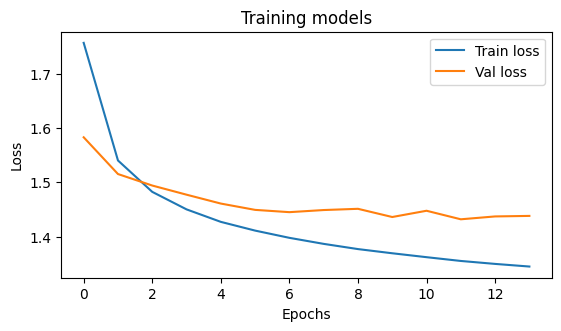

In [32]:
# Test loss result (low): 1.4842933
# Test loss result (high): 2.940201
fig, ax = plt.subplots(figsize=(5.5, 3.2), layout='constrained')

ax.plot(np.arange(len(loss_train)), loss_train, label='Train loss')
ax.plot(np.arange(len(loss_val)), loss_val, label='Val loss')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title("Training models")
ax.legend()
plt.show()

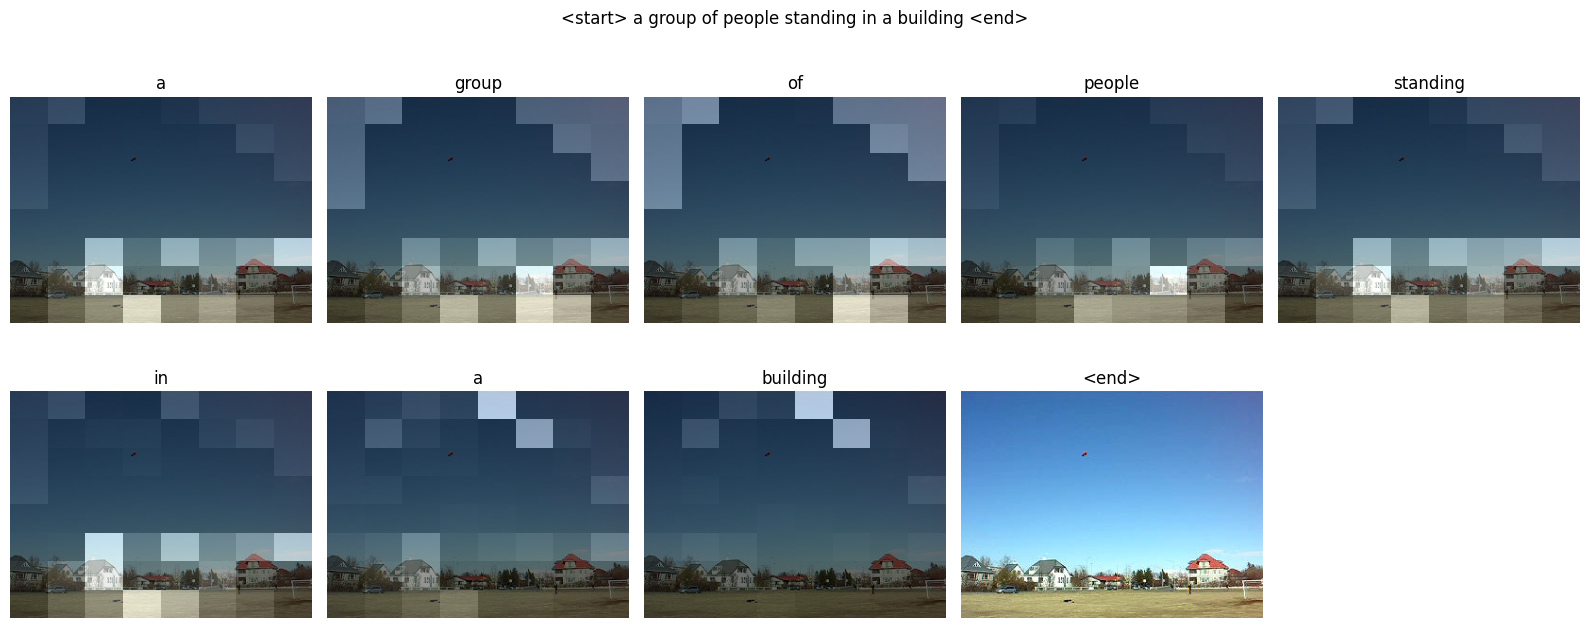

In [52]:
# 1
for (path, _, _) in dataset_test_path.as_numpy_iterator():
    run_and_show_attention(path[0].decode('utf-8'), temperature=0.)
    break

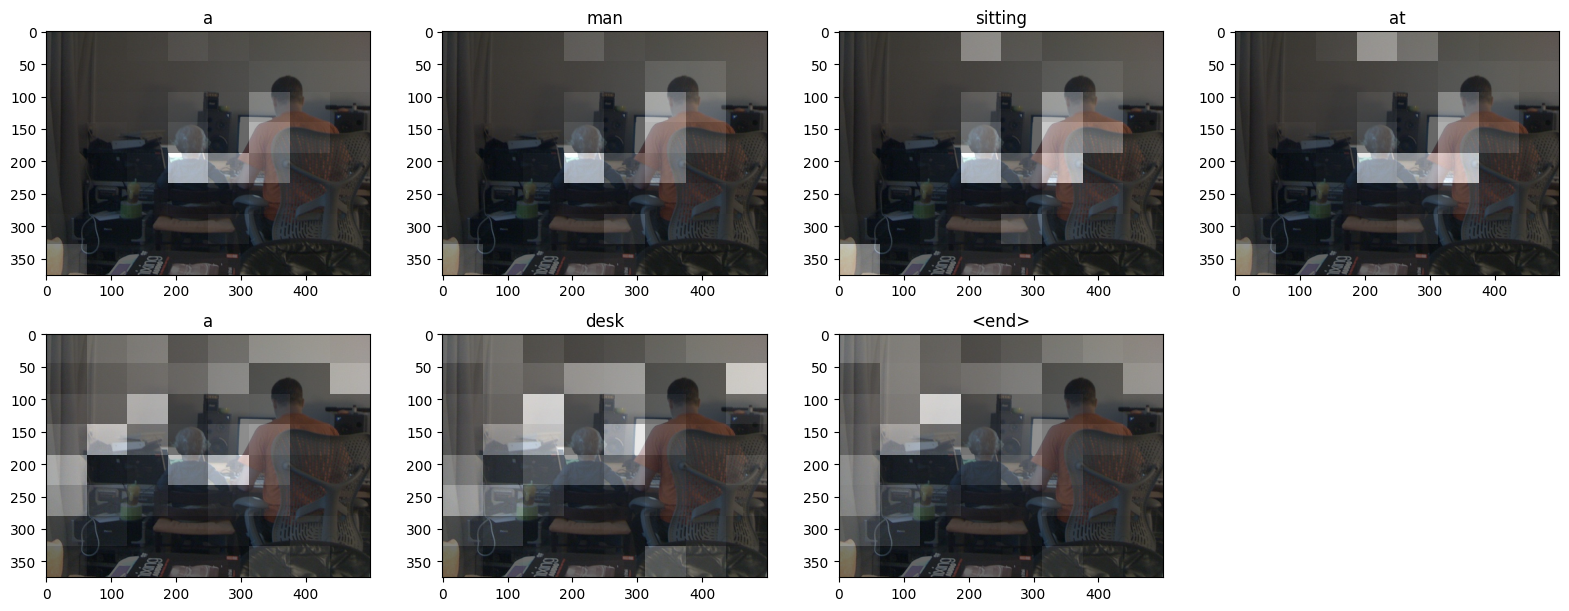

In [39]:
# 2
for (path, img_tensor, caption) in dataset_test_path.as_numpy_iterator():
    result, result_idx, attention_maps = evaluate_one_image(img_tensor)

    img = Image.open(path[0].decode('utf-8'))  # .show()
    plot_attention_maps(img, result.split(), attention_maps)
    break

True caption: <start> some people and two men on brown horses and a building <end>           
[[  3  29  18  10  16  81   5 113 176  10   2  69   4   0   0   0   0   0
    0   0   0   0   0   0]]
Generated caption: <start> a man riding a horse <end>
[  3   2  12  43   2 109   4]


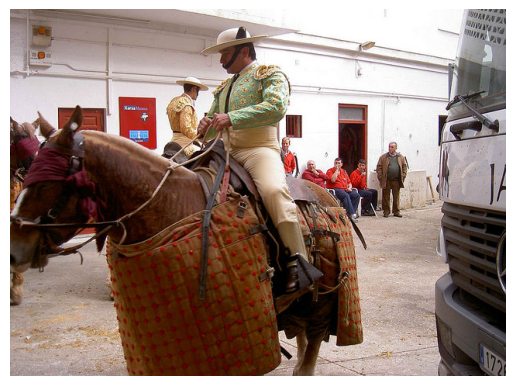

In [37]:
# 3
for (path, img_tensor, caption) in dataset_test_path.as_numpy_iterator():
    result, result_idx, _ = evaluate_one_image(img_tensor, temperature=0.)
    
    result_true = ' '.join([index_to_word(w).numpy().decode('utf-8') for w in caption[0]])
    img = Image.open(path[0].decode('utf-8'))
    
    # print(path, img_tensor, caption)
    plt.imshow(img)
    plt.axis(False)
    print("True caption: " + result_true, caption, sep='\n')
    print("Generated caption: " + result, result_idx, sep='\n')
    break

In [ ]:
input()

In [ ]:
test_filepath = 'test/'
for name in os.listdir(test_filepath):
    path = os.path.join(test_filepath, name)
    img = Image.open(path)

#### !!! Неудачное использование API Keras (должно было быть удобнее) !!!

In [ ]:
class ImageCaptioningModel(Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = BATCH_SIZE

    # @tf.function
    def train_step(self, batch):
        image_tensor, target_caption = batch
        loss = 0.

        # initializing the hidden state for each batch because the captions are not related from image to image
        # batch_size = tf.shape(image_tensor)[0]  # target_caption.shape[0]
        hid_state = tf.zeros([self.batch_size, units])
        dec_input = tf.expand_dims([word_to_index('<start>')] * self.batch_size, 1)

        with tf.GradientTape() as tape:
            features = encoder(image_tensor)

            for i in range(1, max_seq_length):
                # passing the features through the decoder
                predictions, hid_state, _ = decoder([dec_input, hid_state, features])

                loss += self.compute_loss(y=target_caption[:, i], y_pred=predictions)

                # using teacher forcing
                dec_input = tf.expand_dims(target_caption[:, i], 1)

        total_loss = loss / max_seq_length
        
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            if metric.name == "loss":
                metric.update_state(loss)
            else:
                metric.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}  # Return a dict mapping metric names to current value
    
    def call(self, image_tensor, training=False, **kwargs):
        # initializing the hidden state for each batch because the captions are not related from image to image
        batch_size = self.batch_size  # image_tensor.shape[0]
        hid_state = tf.zeros([batch_size, units])
        dec_input = tf.expand_dims([word_to_index('<start>')] * batch_size, 1)
        result_id = [dec_input]
        result_att = []

        features = encoder(image_tensor, training=training)
        for i in range(1, max_seq_length):
            predictions, hid_state, attention_ = decoder([dec_input, hid_state, features], training=training)
            dec_input = tf.argmax(predictions, axis=-1)
            result_att.append(attention_)
        
        return result_id, result_att
    
#     def test_step(self, data):
#         image_tensor, target_caption = data
#         y_pred, _ = self(image_tensor, training=False)
#         self.compute_loss(y=target_caption, y_pred=y_pred)

#         return {m.name: m.result() for m in self.metrics}
    
    def build(self, **kwargs):
        super().build(self.encoder.input_shape)
    
    def save(self, fp, **kwargs):
        self.encoder.save(os.path.join(fp, "enc.h5"))
        self.decoder.save(os.path.join(fp, "dec.h5"))
        
    def load(self, fp):
        self.encoder = load_model(os.path.join(fp, "enc.h5"))
        self.decoder = load_model(os.path.join(fp, "dec.h5"))

In [ ]:
# model = ImageCaptioningModel(encoder, decoder)
# model.compile(tf.optimizers.Adam(), loss=loss_masked)

# model.build()
# model.summary()

# model.fit(dataset_train, epochs=EPOCHS)